# Segmentation

# Database Connection

In [1]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('mysql+pymysql://root:@localhost:3306/housedb')
query = 'select * from house'
df = pd.read_sql(query, con=engine)

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
df.head()

,description,price,buildingArea,landArea,bedroom,bathroom,garage
0,"rumah murah hook tebet timur, tebet, jakarta selatan","3,800,000,000.00",220.00,220.00,3,3,0
1,"rumah modern di tebet dekat stasiun, tebet, jakarta selatan","4,600,000,000.00",180.00,137.00,4,3,2
2,"rumah mewah 2 lantai hanya 3 menit ke tebet, tebet, jakarta selatan","3,000,000,000.00",267.00,250.00,4,4,4
3,"rumah baru tebet, tebet, jakarta selatan","430,000,000.00",40.00,25.00,2,2,0
4,"rumah bagus tebet komp gudang peluru lt 350m, tebet, jakarta selatan","9,000,000,000.00",400.00,355.00,6,5,3


# Clustering

# Segmentation Price

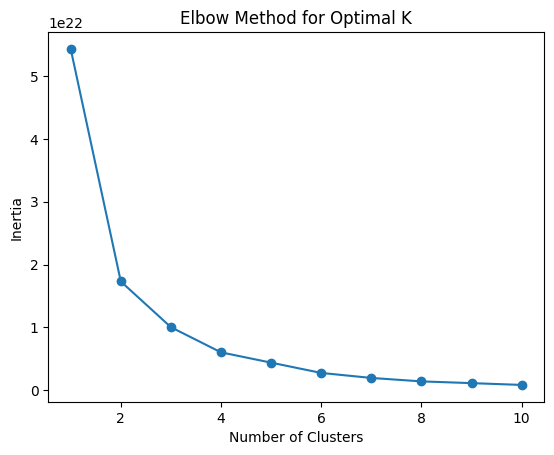

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Menyiapkan data untuk klastering
X = df[['buildingArea', 'landArea', 'bedroom', 'bathroom', 'garage', 'price']]

# Menentukan range jumlah klaster yang ingin diuji
inertia = []
for n_clusters in range(1, 11): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Menampilkan grafik Elbow
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [22]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['price_seg'] = kmeans.fit_predict(df[['price']])

# Map deskripsi langsung di df
seg_map = {
    2: 'Regular',
    0: 'Premium',
    1: 'Luxury'
}
df['price_seg'] = df['price_seg'].map(seg_map)

# Grouping dan agregasi
price_seg_stats = df.groupby('price_seg').agg({
    'buildingArea': 'mean',
    'landArea': 'mean',
    'bedroom': 'mean',
    'bathroom': 'mean',
    'garage': 'mean',
    'price': ['mean', 'min', 'max']
})

# Flatten kolom multi-index biar bersih
price_seg_stats.columns = ['_'.join(col).strip() for col in price_seg_stats.columns.values]

# Hasil akhir tinggal print
price_seg_stats


,buildingArea_mean,landArea_mean,bedroom_mean,bathroom_mean,garage_mean,price_mean,price_min,price_max
price_seg,,,,,,,,
Luxury,666.27,675.54,5.75,5.15,4.33,"31,537,500,010.67","25,000,000,000.00","65,000,000,000.00"
Premium,219.53,174.74,4.46,3.40,1.61,"4,709,849,245.29","430,000,000.00","10,000,000,000.00"
Regular,461.09,436.44,5.45,4.28,2.83,"15,789,993,333.39","10,500,000,000.00","23,000,000,000.00"


In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df[['buildingArea', 'landArea', 'bedroom', 'bathroom', 'garage']]
y = df['price_seg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# clasification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n=== Evaluasi Model Klasifikasi ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# === New Data ===
new_data = pd.DataFrame([{
    'buildingArea': 50,
    'landArea': 60,
    'bedroom': 3,
    'bathroom': 2,
    'garage': 1
}])
predicted_segmen = model.predict(new_data)[0]

info = price_seg_stats.loc[predicted_segmen]

print(f"\n Category Segmentation: {predicted_segmen}")
print(f"Range of price: {info['price_min']:.0f} - {info['price_max']:.0f}")



=== Evaluasi Model Klasifikasi ===
              precision    recall  f1-score   support

      Luxury       0.57      0.80      0.67         5
     Premium       0.96      0.98      0.97       165
     Regular       0.82      0.72      0.77        32

    accuracy                           0.93       202
   macro avg       0.79      0.83      0.80       202
weighted avg       0.93      0.93      0.93       202

[[  4   0   1]
 [  0 161   4]
 [  3   6  23]]

 Category Segmentation: Premium
Range of price: 430000000 - 10000000000
